In [2]:
#read captions

def readTextFile(path):
    with open(path,encoding="utf8") as f:
        captions = f.read()
    return captions

In [3]:
captions=readTextFile("finalFR.txt")

In [4]:
captions=captions.split("\n")

In [5]:
# print(len(captions))
print(captions[0])

1000092795.jpg, Two young guys with shaggy hair look at their hands while hanging out in the yard .


In [39]:
 import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### 

In [6]:
first,second=captions[0].split(',')
print(first.split(".")[0])
print(second)



1000092795
 Two young guys with shaggy hair look at their hands while hanging out in the yard .


In [7]:
#dictionary to map each image with list of options it has
descriptions={}


for x in captions:
    
    first,second=x.split(',')
    img_name=first.split(".")[0]
    
    #if image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    
    descriptions[img_name].append(second)
    
    
    


In [8]:
descriptions["1283466"]

[' There is a man wearing construction gear standing next to a bulldozer that is picking up rubble and debris .',
 ' A backhoe is on top of a pile of rubble from a demolished building .',
 ' A yellow backhoe is tearing down a brick building .',
 ' Something gets knocked down by a bulldozer .',
 ' A house is being demolished .']

(-0.5, 332.5, 499.5, -0.5)

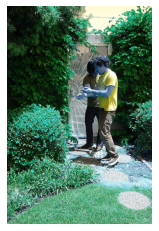

In [9]:
IMG_PATH="flickr30/"
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread(IMG_PATH+"1000092795.jpg")
if(img is not None):
    cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(np.real(img))
plt.axis("off")

In [10]:
##data cleaning

import pandas as pd
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add

In [11]:
##reduce vocab size-less overfitting and less time to compute remove numbers punctuation and everything which is not an alphabet
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
#     sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence


In [12]:
clean_text("a cat is sitting over house number #64...     ...............")

'a cat is sitting over house number'

In [13]:
#clean all captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])
        

In [14]:
#write the data to a text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

In [15]:

descriptions=None
with open("descriptions_1.txt",'r') as f:
    descriptions=f.read()
    
json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)



In [16]:
print(type(descriptions))

<class 'dict'>


In [17]:
#vocab
vocab=set() #set stores all unique words
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab size:%d"%len(vocab))
    

Vocab size:18078


In [18]:
#total no. of words across all the sentences
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("total words %d"%len(total_words))

total words 1955183


In [19]:
#filtering words from vocab acc to threshhold 

import collections

counter=collections.Counter(total_words)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

18078


In [20]:
#sorting acc to freq count

sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])


#filter
threshold=12
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]

In [21]:
print(len(total_words))

4716


In [22]:
comments=readTextFile("finalFR.txt")

In [23]:
comments=comments.split("\n")

In [24]:
with open("train.txt","a") as f:
    for x in comments:
        fi,se=x.split(',')
        f.write(fi+"\n")

In [25]:
train_file_data=readTextFile("train.txt")

In [26]:
train=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
#do same for test data


In [27]:
train_descriptions={}

for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append="startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [28]:
for k,c in train_descriptions.items():
    for j in range(len(c)):
        c[j]=clean_text(c[j])

In [29]:
train_descriptions["1000092795"]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in a yard endseq',
 'startseq a man in a blue shirt standing in a garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [30]:
#transfer learning

#1.Image feature Extraction

model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [31]:
 model_new=Model(model.input,model.layers[-2].output)

In [32]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0) #reshape() would have also worked
    
    #normalisation
    img=preprocess_input(img)
    return img

In [33]:
# img=preprocess_img(IMG_PATH+"1000092795.jpg")
# plt.imshow(img[0])
# plt.axis("off")
# plt.show()

In [34]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
#     print(feature_vector.shape)
    return feature_vector

In [35]:
encode_image(IMG_PATH+"1000092795.jpg")

array([0.19759566, 0.18138032, 0.20668261, ..., 0.35860714, 0.64572656,
       0.97927624], dtype=float32)

In [40]:

start=time()
encoding_train={}
#image_id ----->feature_vector extracted from Resnet Image



for ix,img_id in enumerate(train):
    img_path=IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id]=encode_image(img_path)
    
    if ix%10000==0:
        print("encoding in progress time step %d "%ix)

end_t=time()
print("total time taken :",end_t-start)

encoding in progress time step 0 
encoding in progress time step 10000 
encoding in progress time step 20000 
encoding in progress time step 30000 
encoding in progress time step 40000 
encoding in progress time step 50000 
encoding in progress time step 60000 
encoding in progress time step 70000 
encoding in progress time step 80000 
encoding in progress time step 90000 
encoding in progress time step 100000 
encoding in progress time step 110000 
encoding in progress time step 120000 
encoding in progress time step 130000 
encoding in progress time step 140000 
encoding in progress time step 150000 
encoding in progress time step 160000 
encoding in progress time step 170000 
encoding in progress time step 180000 
encoding in progress time step 190000 
encoding in progress time step 200000 
encoding in progress time step 210000 
encoding in progress time step 220000 
encoding in progress time step 230000 
encoding in progress time step 240000 
encoding in progress time step 250000 


In [ ]:
# file = open('encoded_train_features.pkl', 'rb')
# unordered_map<int,int>> map:
#     for(i in range(6000)):
#         word_to_idx={}
#         idx_to_word={}
#         for i,word in enumerate(total_words):
#             word_to_idx[word]=i+1
#             idx_to_word[1+1]=word
# dump information to that file
# data = pickle.load(file)

# # close the file
# file.close()

In [41]:
#store everything to the disk 


with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [42]:
#encode test data also and store in pickle file

In [43]:
#preprocessing captions
word_to_idx={}
idx_to_word={}






for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [44]:
word_to_idx["dog"]
print(len(idx_to_word))

4716


In [45]:
#two special words start seq and end seq 
idx_to_word[4717]='startseq'
word_to_idx['startseq']=4717



idx_to_word[4718]='endseq'
word_to_idx['endseq']=4718

vocab_size=len(word_to_idx)+1
print("Vocab Size",vocab_size)

Vocab Size 4719


In [46]:
max_len=0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))
print(max_len)

80


In [47]:
## Data loader(Generator)

def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    
    
    X1,X2,y=[],[],[]
    
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            
            photo=encoding_train[key]
            
            for desc in desc_list:
                
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    
                    
                    #0 denotes padding word
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    
                    X1,X2,y=[],[],[]
                    n=0
                    
                    
                    


In [48]:
f=open("glove.6B.50d.txt",encoding='utf8')

In [49]:
#Word Embeddings

embedding_index={}


for line in f:
    values=line.split()
   

    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding
    

    
    

In [50]:
f.close()

In [53]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        
        
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
            
            
    return matrix
    

In [54]:
embedding_matrix=get_embedding_matrix()

embedding_matrix.shape


(4719, 50)

In [55]:
# embedding_matrix[4718]

In [56]:
#Model Architecture

input_img_features=Input(shape=(2048,))

inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)



In [57]:
#captions as input

input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)


In [58]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

#combined model

model=Model(inputs=[input_img_features,input_captions],outputs=outputs)


In [59]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 50)       235950      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [60]:
#preinitialize embedding layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False


In [61]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [62]:
#training of model

epochs=25
batch_size=3
steps=len(train_descriptions)//batch_size


In [63]:
def train():
    
    for i in range(epochs):
        generator =data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_weights/model_'+str(i)+'.h5')

In [64]:
train()

C:\Users\Tushar\AppData\Local\Temp/ipykernel_15976/4022939330.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


10594/10594 [==============================] - 5483s 517ms/step - loss: 3.7992


c:\users\tushar\appdata\local\programs\python\python38\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


10594/10594 [==============================] - 4015s 379ms/step - loss: 3.1208


In [65]:
model=load_model('./model_weights/model_9.h5')
